In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/My Drive/RL/amalearn'

/content/drive/My Drive/RL/amalearn


In [4]:
!pip install -e .

Obtaining file:///content/drive/My%20Drive/RL/amalearn
  Running setup.py develop for amalearn


In [5]:
!pip install plotting

##LIBRARIES

In [6]:
from amalearn.reward import RewardBase
from amalearn.agent import AgentBase
from amalearn.environment import EnvironmentBase
import random

In [7]:
import gym
import numpy as np
import operator
from IPython.display import clear_output
from time import sleep
from gym.envs.registration import register
from gym import wrappers
import itertools
import sys
import tqdm
from collections import defaultdict
import plotting
import matplotlib
import matplotlib.style
matplotlib.style.use('ggplot')
import time

##ENVIRONMENT

In [28]:
import numpy as np
import copy
from gym import Env
import datetime

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
action_name = [LEFT,DOWN,RIGHT,UP]

def set_max_min(var,maximum,minimum):
    return min(max(var,minimum),maximum)

def make_map(studentNum):
    np.random.seed(studentNum)  
    move = np.zeros(6)
    idx = np.random.choice(range(6),size=3,replace=False)
    move[idx] = 1

    point = [0,0]
    lowprobs = [tuple(point)]

    for m in move:
        if m:
            point[0] += 1
        else:
            point[1] += 1
        lowprobs.append(tuple(point))
    
    map = np.random.rand(4,4)
    idx = np.array(lowprobs)

    map[idx[:,0],idx[:,1]] = 0.001 
    map[0,0] = 0.0
    map[3,3] = 0.0 

    return map


class NSFrozenLake(EnvironmentBase):
    def __init__(self,studentNum:int=126, nonStationary = True):
        self.studentNum = studentNum
        self.nonStationary = nonStationary
        
        np.random.seed(self.studentNum)
        ##### changed {
        self.beginMap = make_map(self.studentNum) #*2
        self.beginMap[self.beginMap>1] = 1
        self.endMap = make_map(self.studentNum + 100)
        
        self.changeDir = self.endMap - self.beginMap
        self.changeDir *= 1/11000

        self.fixedMap = self.beginMap

        np.random.seed(datetime.datetime.now().microsecond)
        
        self.map = copy.deepcopy(self.fixedMap)
        self.time = 0
        self.reset()
        # self.state = [0,0]
        

    def reset(self):
        self.NSreset()
        if not self.nonStationary:
            self.map = copy.deepcopy(self.fixedMap)
            self.time = 0

        return self.state

    def NSreset(self):
        self.time += 1
        self.map += self.changeDir

        self.map[self.map>0.95]=0.95
        self.map[self.map<0.0]=0.0

        self.state = (0,0)
        self.done = False
        return self.state
    
    def states_transitions(self, state, action):
        x = state[0]
        y = state[1]
        states = np.array([[x,y-1], [x,y+1], [x-1 ,y], [x+1,y] ])

        if action == UP:
            selected = states[2]
        if action == DOWN:
            selected = states[3]
        if action == RIGHT:
            selected = states[1]
        if action == LEFT:
            selected = states[0]

        zero = np.zeros((4,2)).astype(int)
        three = (3 * np.ones((4,2))).astype(int)
        output = np.maximum(np.minimum(states, three),zero)
        output, indices = np.unique(output, axis = 0, return_counts= True)
        
        selected = np.maximum(np.minimum(selected, three[0]), zero[0])
        probs = indices * 0.025
        probs[np.argmax(np.sum(selected == output, axis = 1))] += 0.9

        return list(zip(output[:,0],output[:,1])), probs
    
    def possible_consequences(self,action:int,state_now=None):

        if state_now==None:
            state_now = self.state

        state = [state_now[0],state_now[1]]
        states, probs = self.states_transitions(state, action)
        aa = np.array(states) 
        fail_probs = self.map[(aa[:,0]),(aa[:,1])]
        dones = np.sum(aa == 3, axis = 1) == 2
        return states, probs, fail_probs,dones
    
    def possible_consequences_val_iter(self,action:int,state_now=None):
        if state_now==None:
            state_now = self.state
        state = [state_now[0],state_now[1]]
        states, probs = self.states_transitions(state, action)
        aa = np.array(states) 
        fail_probs = self.map[(aa[:,0]),(aa[:,1])]
        dones = np.sum(aa == 3, axis = 1) == 2
        reward=np.zeros(len(probs))
        for p in range(len(probs)):
          if state == states[p]:
            r=0
          else:
            r=-1
          if dones[p]:
              r += 50
          elif np.random.rand()< fail_probs[p]:
              r -= 10
          reward[p] = r
        return states, probs, fail_probs,dones,reward
    
    def step(self, a:int):
        if not (a in range(4)):
            raise Exception("action is not in range !!!")
        
        states, probs, fail_probs,dones = self.possible_consequences(a)
        
        next_idx = np.random.choice(np.arange(len(states)), p = probs)
        next_state = states[next_idx]
        self.state = tuple(next_state)
        
        self.done = dones[next_idx]

        r = -1

        if self.done:
            r += 50
        elif np.random.rand()< fail_probs[next_idx]:
            r -= 10
            self.done = True

        return (self.state, r, self.done, probs,{})

    def render(self,state=None):
        if state == None:
            state = self.state

        out = ""
        for i in range(4):
            out += "\n------------------------------\n| "
            for j in range(4):
                if (i,j) == state:
                    out += "\033[44m{:.3f}\033[0m | ".format(self.map[i,j])
                else :
                    out += "{:.3f} | ".format(self.map[i,j])

        out += "\n------------------------------"
        print(out)
   
    def calculate_reward(self, action):
        return 

    def terminated(self):
        return 

    def observe(self):
        return 
    
    def next_state(self, action):
        return

    def close(self):
        return



##VALUE_ITERATION

In [29]:
class Agent(AgentBase):
    def __init__(self, id, environment, value, policy):
      self.environment = environment
      self.V = value
      self.policy = policy
      super(Agent, self).__init__(id, environment)
      self.discount = 0.9
      self.theta = 0.001
      
    def bellman_equation(self, state, action):
      returns = []
      for a in action_name:
        q=0
        (states, probs, fail_probs, dones,reward )= self.environment.possible_consequences_val_iter(a,state)
        for k in range(len(probs)):
          q += (probs[k]*(reward[k]+self.discount*self.V[states[k][0],states[k][1]]))
        returns.append(q)
      returns = np.array(returns)
      max_element = np.amax(returns)
      p = np.argmax(returns)
      return max_element, p

    def value_iteration(self):
      while True:
        max_value_change = 0
        for i in range(4):
          for j in range(4):
            old_value = self.V.copy()
            new_state_value,p = self.bellman_equation([i,j], self.V[i, j])
            self.V[i, j] = new_state_value
            self.policy[i][j][p] = 1
        max_value_change = abs(old_value - self.V).max()
        if max_value_change < self.theta:
          break
      self.policy = [[[ 0 for _ in range(4)] for _ in range(4)] for _ in range(4)]
      for i in range(4):
          for j in range(4):
            self.state = [i,j]
            new_state_value,p = self.bellman_equation([i,j], self.V[i, j])
            self.policy[i][j][p] = 1
      # print('self_policy',self.policy)
      
      return self.V, self.policy

    def calc_QSA(self):
      q, p = self.value_iteration()
      Q_values = []
      for i in range(4):
        qq = []
        for j in range(4):
          left_Q = 0
          down_Q = 0
          right_Q = 0
          up_Q = 0
          if 0<=i< 4 and 0<=j-1<4:
            left_Q = q[i][j] +  q[i][j-1]
          if 0<=i+1<4 and 0<=j<4:
            down_Q = q[i][j] +  q[i+1][j]
          if 0<=i<4 and 0<=j+1<4:
            right_Q = q[i][j] +  q[i][j+1]
          if 0<=i-1<4 and 0<=j<4:
            up_Q = q[i][j] +  q[i-1][j]
          
          qq.append([left_Q,down_Q,right_Q,up_Q])
        Q_values.append(qq)
      return Q_values

In [30]:
env = NSFrozenLake()
id = '1'
value = np.zeros((4,4))
policy = [[[ 0 for _ in range(4)] for _ in range(4)] for _ in range(4)]

agent_mb = Agent(id, env, value, policy)
# agent1.value_iteration()
# print(agent_mb.calc_QSA())

In [141]:
print(agent_mb.policy)

[[[0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 1, 0, 0]], [[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 1, 0, 0]], [[0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0]], [[0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0]]]


In [142]:
print(agent_mb.V)

[[253.37949637 285.02240888 319.84685875 358.73957456]
 [284.5299542  319.74371813 360.32097566 405.10689893]
 [310.63029536 350.87822171 405.59530663 457.43939852]
 [339.81433589 393.90427341 456.914935   460.84813545]]


In [143]:
print("order of actions is:left,down,right,up")
Q_values = []
for i in range(4):
  for j in range(4):
    left_Q = 0
    down_Q = 0
    right_Q = 0
    up_Q = 0
    if 0<=i< 4 and 0<=j-1<4:
      left_Q = agent_mb.V[i][j] +  agent_mb.V[i][j-1]
    if 0<=i+1<4 and 0<=j<4:
      down_Q = agent_mb.V[i][j] +  agent_mb.V[i+1][j]
    if 0<=i<4 and 0<=j+1<4:
      right_Q = agent_mb.V[i][j] +  agent_mb.V[i][j+1]
    if 0<=i-1<4 and 0<=j<4:
      up_Q = agent_mb.V[i][j] +  agent_mb.V[i-1][j]
    
      
    Q_values.append([left_Q,down_Q,right_Q,up_Q])
    
    print("Q(",i,j,")=",[left_Q,down_Q,right_Q,up_Q])

order of actions is:left,down,right,up
Q( 0 0 )= [0, 537.9094505652383, 538.4019052432068, 0]
Q( 0 1 )= [538.4019052432068, 604.7661270042038, 604.8692676248177, 0]
Q( 0 2 )= [604.8692676248177, 680.1678344128698, 678.5864333072794, 0]
Q( 0 3 )= [678.5864333072794, 763.8464734924743, 0, 0]
Q( 1 0 )= [0, 595.1602495544605, 604.2736723262353, 537.9094505652383]
Q( 1 1 )= [604.2736723262353, 670.6219398370836, 680.0646937922559, 604.7661270042038]
Q( 1 2 )= [680.0646937922559, 765.9162822914785, 765.4278745980646, 680.1678344128698]
Q( 1 3 )= [765.4278745980646, 862.5462974565505, 0, 763.8464734924743]
Q( 2 0 )= [0, 650.4446312433167, 661.5085170653088, 595.1602495544605]
Q( 2 1 )= [661.5085170653088, 744.7824951173096, 756.4735283363061, 670.6219398370836]
Q( 2 2 )= [756.4735283363061, 862.5102416320541, 863.0347051499646, 765.9162822914785]
Q( 2 3 )= [863.0347051499646, 918.2875339716138, 0, 862.5462974565505]
Q( 3 0 )= [0, 0, 733.7186092953177, 650.4446312433167]
Q( 3 1 )= [733.7186092

##ON-POLICY MONTE CARLO

In [203]:
class MCAgent(AgentBase):
    def __init__(self, id, environment, policy, Qsa):
      self.environment = environment
      self.policy = policy
      super(MCAgent, self).__init__(id, environment)
      self.discount = 0.9
      self.epsilon = 0.05
      self.Q_s_a = Qsa
      self.episodes = 4000
      self.decay = 0.999

    def create_random_policy(self):
      policy = [[[ 0 for _ in range(4)] for _ in range(4)] for _ in range(4)]
      for i in range(4):
        for j in range(4):
          for action in range(4):
              policy[i][j][action] = self.epsilon/4
          amax = np.random.randint(4,size=1)
          policy[i][j][amax[0]] = self.epsilon/4 + 1-self.epsilon
      return policy

    
    def generate_episode(self, policy, state, display=False):
      self.environment.reset()
      episode = []
      finished = False
      while not finished:
        s = state    
        if display:
          clear_output(True)
          self.environment.render(state)
          sleep(0.1)
        timestep = []
        timestep.append(s)
        n = random.uniform(0, sum(policy[s[0]][s[1]]))
        
        top_range = 0
        c = -1
        for prob in policy[s[0]][s[1]]:
          top_range += prob
          c+=1
          if n < top_range:
            action = c
            break   
        
        state, reward, finished, probs, info =  self.environment.step(action)
        timestep.append(action)
        timestep.append(reward)
        
        episode.append(timestep)
          
      if display:
        clear_output(True)
        self.environment.render(state)
        sleep(0.05)
      
      return episode


    def monte_carlo(self, policy = None):
      if not policy:
        policy = self.create_random_policy()  
          
      QSA = [[[ 0 for _ in range(4)] for _ in range(4)] for _ in range(4)]
      self.Q_s_a = QSA
      returns = [[[ 0 for _ in range(4)] for _ in range(4)] for _ in range(4)]
      
      sum_r_per_episode = []
      num_of_r_per_episode = []
      # self.epsilon = 0.1
      for _ in range(self.episodes): 
        sum_r = 0
        cnt = 0
        G = 0 
        episode = self.generate_episode(policy, self.environment.state, display=False) 
        for i in reversed(range(0, len(episode))): 
          s_t, a_t, r_t = episode[i]

          sum_r += r_t
          cnt += 1

          G = self.discount*G + r_t 
          s_t = list(s_t)
        
          if not (s_t and a_t) in [(x[0], x[1]) for x in episode[0:i]]: 
            if returns[s_t[0]][s_t[1]][a_t]: 
              returns[s_t[0]][s_t[1]][a_t].append(G)
            else:
              returns[s_t[0]][s_t[1]][a_t] = [G]   
        
            self.Q_s_a[s_t[0]][s_t[1]][a_t] = sum(returns[s_t[0]][s_t[1]][a_t]) / len(returns[s_t[0]][s_t[1]][a_t]) 
            
            A_star = np.argmax(np.array(self.Q_s_a[s_t[0]][s_t[1]]))

            for a in range(len(policy[s_t[0]][s_t[1]])): 
              if a == A_star:
                  policy[s_t[0]][s_t[1]][a] = 1 - self.epsilon + (self.epsilon / 4)
              else:
                  policy[s_t[0]][s_t[1]][a] = (self.epsilon / 4)
        
        sum_r_per_episode.append(sum_r)  
        num_of_r_per_episode.append(cnt)
        # self.epsilon *= self.decay

      window_size = 40
      print(len(sum_r_per_episode))
      average_reward =[]
      iter=0
      while iter < self.episodes:
        total_sum = 0
        total_cnt = 0
        for j in range(window_size):
          # print(iter,j)
          total_sum += sum_r_per_episode[iter+j]
          total_cnt += num_of_r_per_episode[iter+j]
        average_reward.append(total_sum/total_cnt)
        iter+=40
      return policy, average_reward

In [204]:
import matplotlib.pyplot as plt
env = NSFrozenLake()
id = '1'
policy = None
Qsa = []
agent1 = MCAgent(id, env,policy, Qsa)
average_r = []
start = time.time()
for i in range(20):
  print(i)
  p, r = agent1.monte_carlo()
  average_r.append(r)
end = time.time()
# plt.plot(average_r)
print("run time =",end-start)

0
4000
1
4000
2
4000
3
4000
4
4000
5
4000
6
4000
7
4000
8
4000
9
4000
10
4000
11
4000
12
4000
13
4000
14
4000
15
4000
16
4000
17
4000
18
4000
19
4000
run time = 799.6453411579132


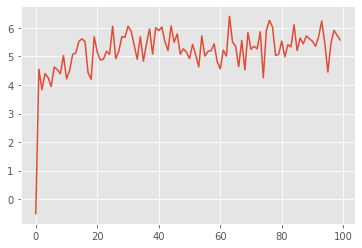

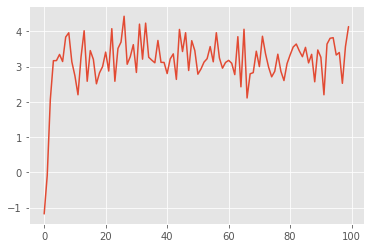

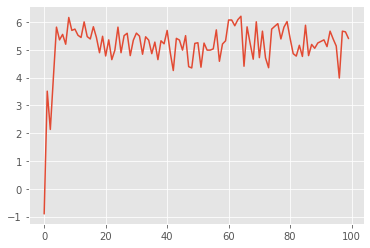

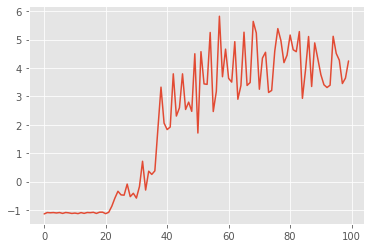

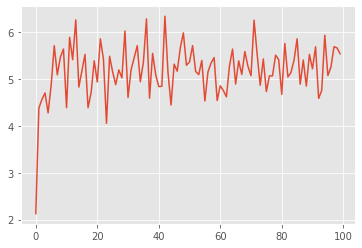

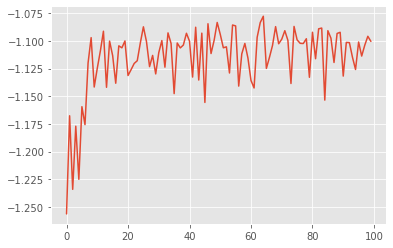

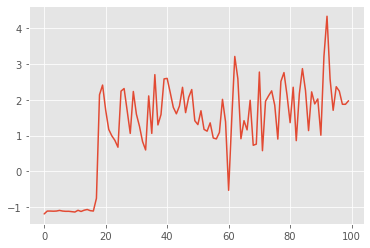

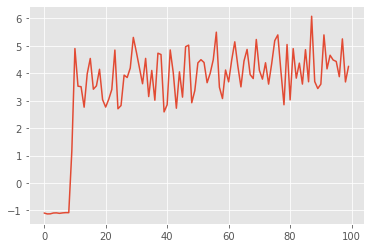

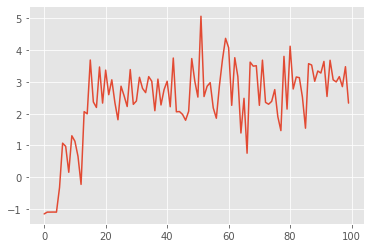

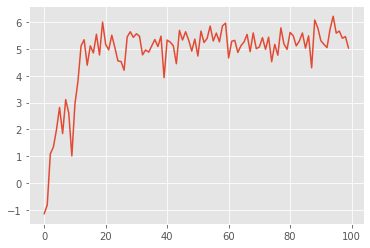

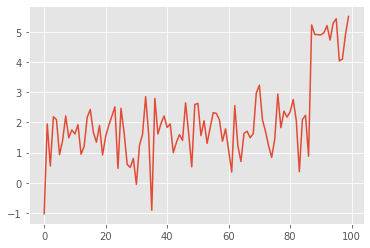

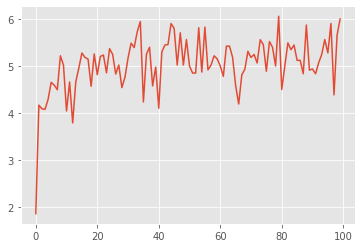

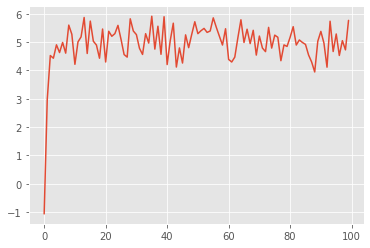

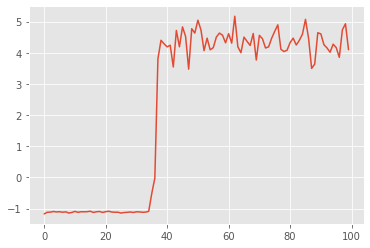

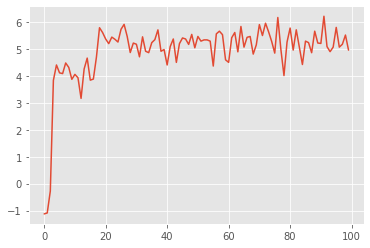

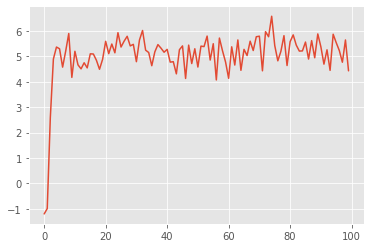

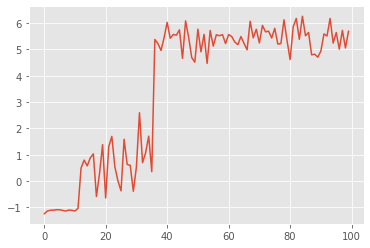

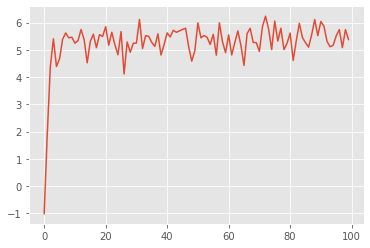

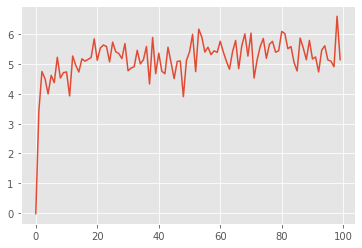

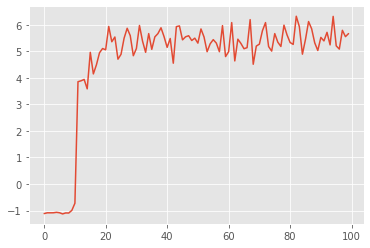

In [205]:
for i in range(20):
  plt.figure()
  plt.plot(average_r[i])

In [206]:
print(p)

[[[0.0125, 0.0125, 0.9624999999999999, 0.0125], [0.0125, 0.9624999999999999, 0.0125, 0.0125], [0.0125, 0.9624999999999999, 0.0125, 0.0125], [0.0125, 0.9624999999999999, 0.0125, 0.0125]], [[0.0125, 0.0125, 0.9624999999999999, 0.0125], [0.0125, 0.0125, 0.9624999999999999, 0.0125], [0.0125, 0.0125, 0.9624999999999999, 0.0125], [0.0125, 0.9624999999999999, 0.0125, 0.0125]], [[0.0125, 0.0125, 0.9624999999999999, 0.0125], [0.0125, 0.0125, 0.0125, 0.9624999999999999], [0.0125, 0.0125, 0.9624999999999999, 0.0125], [0.0125, 0.9624999999999999, 0.0125, 0.0125]], [[0.0125, 0.0125, 0.0125, 0.9624999999999999], [0.0125, 0.9624999999999999, 0.0125, 0.0125], [0.0125, 0.9624999999999999, 0.0125, 0.0125], [0.0125, 0.9624999999999999, 0.0125, 0.0125]]]


##SARSA

In [223]:
class SarsaAgent(AgentBase):
    def __init__(self, id, environment, policy):
      self.environment = environment
      self.policy = policy
      super(SarsaAgent, self).__init__(id, environment)
      self.discount = 0.9
      self.epsilon = 0.1
      self.episodes = 40000
      self.alpha = 0.1

    def action_epsilon_greedy(self, q, s):
      if np.random.rand() > self.epsilon:
        return np.argmax(q[s[0]][s[1]])
      else: 
        return np.random.randint(4)

    def sarsa(self):
      
      q = [[[ 0 for _ in range(4)] for _ in range(4)] for _ in range(4)]
      
      sum_r_per_episode = []
      num_of_r_per_episode = []
      for i in range(self.episodes):
        sum_r = 0
        cnt = 0
        done = False
        s = self.environment.reset()
        s = list(s)
        a = self.action_epsilon_greedy(q, s)
        while not done:
            new_s, reward, done, probs, info = self.environment.step(a)
            new_s = list(new_s)
            sum_r += reward
            cnt += 1
            new_a = self.action_epsilon_greedy(q, new_s)
            target = reward + self.discount * q[new_s[0]][new_s[1]][new_a]
            delta = target - q[s[0]][s[1]][a]
            q[s[0]][s[1]][a] += self.alpha * delta
            s = new_s
            a = new_a
        
        sum_r_per_episode.append(sum_r)  
        num_of_r_per_episode.append(cnt)
      window_size = 40
      average_reward =[]
      iter=0
      while iter < self.episodes:
        total_sum = 0
        total_cnt = 0
        for j in range(window_size):
          total_sum += sum_r_per_episode[iter+j]
          total_cnt += num_of_r_per_episode[iter+j]
        average_reward.append(total_sum/total_cnt)
        iter+=40

      return q, average_reward

In [224]:
import matplotlib.pyplot as plt
env = NSFrozenLake()
id = '1'
policy = None
Qsa = []
agent1 = SarsaAgent(id, env,policy)
average_r = []
start = time.time()
for i in range(20):
  print(i)
  q, r = agent1.sarsa()
  average_r.append(r)
end = time.time()
print("run time =",end-start)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
run time = 1367.797589302063


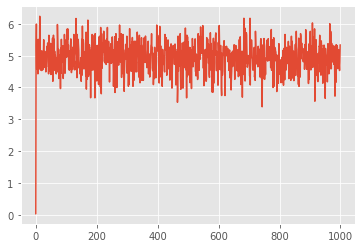

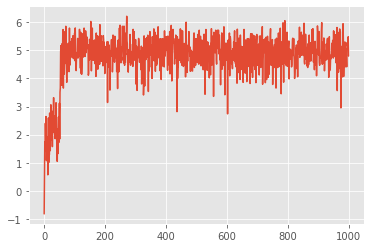

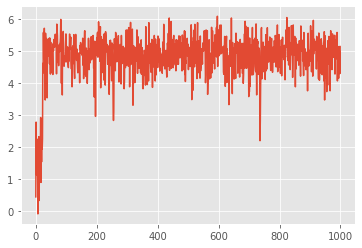

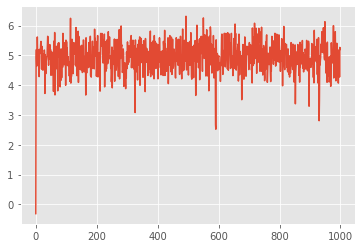

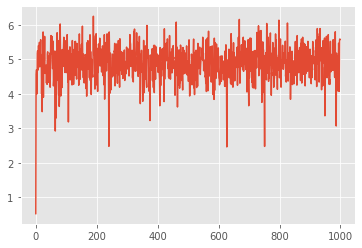

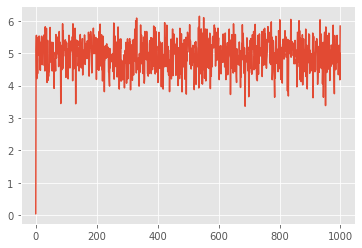

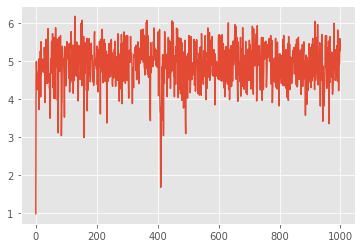

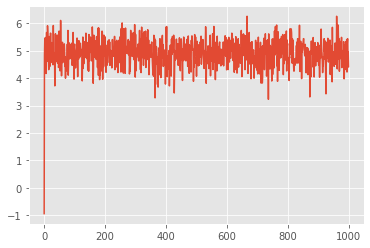

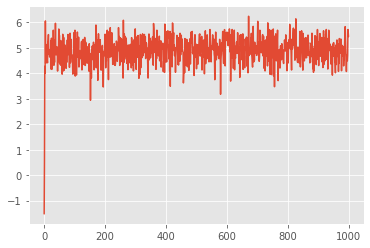

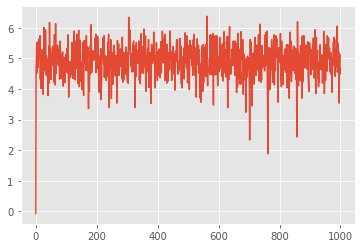

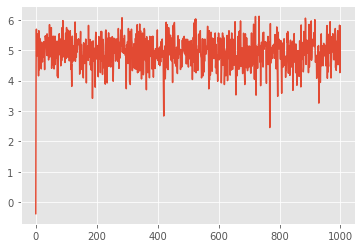

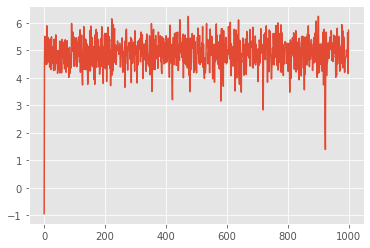

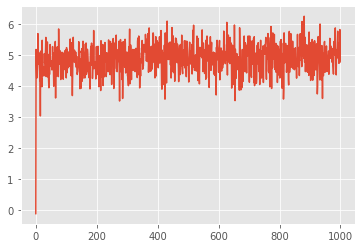

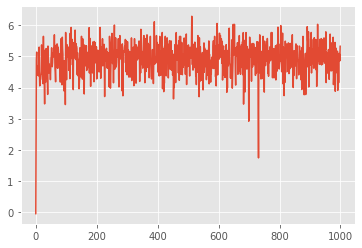

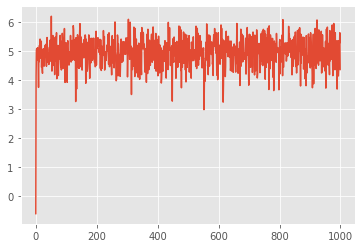

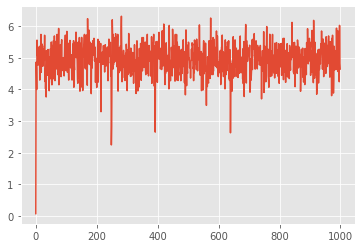

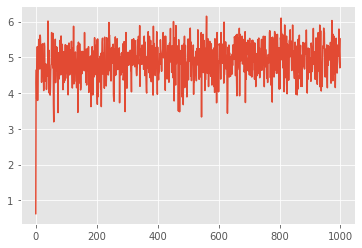

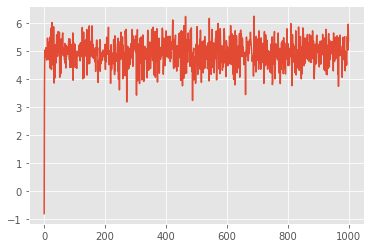

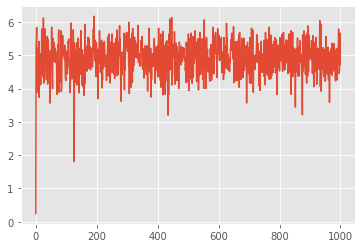

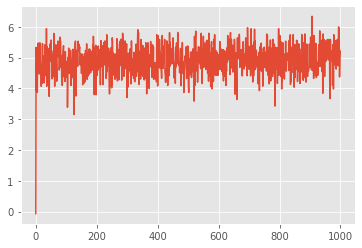

In [225]:
for i in range(20):
  plt.figure()
  plt.plot(average_r[i])

In [115]:
q

[[[15.879250677273658,
   18.214672826632555,
   15.479859723902344,
   16.40154624107891],
  [13.162423703970667,
   22.012204116287126,
   15.863022165264653,
   13.84063212291628],
  [9.938374347005679,
   28.55866252722065,
   18.613468196499426,
   11.630074732885573],
  [13.9388989385317,
   31.95426009550135,
   11.511853695469416,
   10.45327892754193]],
 [[18.157362027227826,
   13.187899813505142,
   21.340317327152587,
   15.725426269165935],
  [18.51389417289445,
   22.38403824018157,
   29.316532245831144,
   13.299309274824196],
  [22.562003506478504,
   27.738014207955604,
   34.53108346189439,
   21.38164542502859],
  [28.34996512800648,
   41.55838948407633,
   33.48241793386491,
   21.557523798910083]],
 [[9.445518530590103,
   -0.5229254617632034,
   11.80043008409561,
   18.50764204196811],
  [10.884084597399676,
   -0.6649726750485178,
   30.640050056245304,
   20.7287384468749],
  [13.417141305812962,
   0.2991849231639687,
   37.44901962387639,
   25.463592538066

##Q-LEARNING

In [219]:
class QLearningAgent(AgentBase):
    def __init__(self, id, environment,policy):
      self.environment = environment
      self.policy = policy
      super(QLearningAgent, self).__init__(id, environment)
      self.discount = 0.9
      self.epsilon = 0.1
      self.episodes = 40000
      self.alpha = 0.1
      self.decay = 0.999
    def action_epsilon_greedy(self, q, s):
      if np.random.rand() > self.epsilon:
        return np.argmax(q[s[0]][s[1]])
      else: 
        return np.random.randint(4)


    def q_learning(self):
      q = [[[ 0 for _ in range(4)] for _ in range(4)] for _ in range(4)]
      sum_r_per_episode = []
      num_of_r_per_episode = []
      self.alpha = 0.1
      for i in range(self.episodes):
        sum_r = 0
        cnt = 0
        done = False
        s = self.environment.reset()
        s = list(s)
        while not done:
          # print(s)
          a = self.action_epsilon_greedy(q, s)
          new_s, reward, done, probs, info = self.environment.step(a)
          sum_r += reward
          cnt += 1
          new_s = list(new_s)
          a_max = np.argmax(q[new_s[0]][new_s[1]]) 
          target = reward + self.discount * q[new_s[0]][new_s[1]][a_max]
          delta = target - q[s[0]][s[1]][a]
          q[s[0]][s[1]][a] += self.alpha * delta
          s = new_s
        self.alpha *= self.decay
        
        sum_r_per_episode.append(sum_r)  
        num_of_r_per_episode.append(cnt)
      window_size = 40
      average_reward =[]
      iter=0
      while iter < self.episodes:
        total_sum = 0
        total_cnt = 0
        for j in range(window_size):
          total_sum += sum_r_per_episode[iter+j]
          total_cnt += num_of_r_per_episode[iter+j]
        average_reward.append(total_sum/total_cnt)
        iter+=40
      return q, average_reward

In [220]:
import matplotlib.pyplot as plt
env = NSFrozenLake()
id = '1'
policy = [[[ 0 for _ in range(4)] for _ in range(4)] for _ in range(4)]
agent2 = QLearningAgent(id, env,policy)
average_r = []
start = time.time()
for i in range(1):
  print(i)
  q, r = agent2.q_learning()
  average_r.append(r)
end = time.time()
print("run time =",end-start)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
run time = 1441.3787972927094


In [221]:
q

[[[17.05004618471398,
   21.594624697371025,
   17.495292961407678,
   17.706049935816406],
  [0.8254608288539499,
   25.599294699545435,
   1.7438071602760763,
   1.1557134787454504],
  [1.4574867104777363,
   29.43347852299821,
   3.6339411119784093,
   0.5167663502911329],
  [0.7465466121197434,
   31.37617250145453,
   0.023214122262349687,
   1.6024876835118305]],
 [[19.63718460064634,
   12.462735847532773,
   25.349393171732952,
   14.896491967986359],
  [20.063035893978945,
   13.22283110155624,
   29.99137897227023,
   15.184398148821657],
  [23.954226702351285,
   25.291795304448247,
   35.42207204746606,
   19.956376311228617],
  [28.00493011019235,
   41.229651482493615,
   33.188709712676996,
   17.45704165469367]],
 [[-0.9836436367140926,
   -1.9397141240504423,
   1.0612719766452092,
   19.82166458468727],
  [0.4991166483813229,
   -1.2591311001109626,
   -0.370803996297146,
   24.05267286148795],
  [0.08681102536830196,
   -0.4742514624849211,
   40.603862956116025,
   

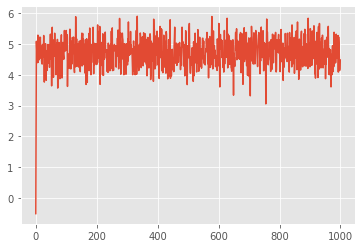

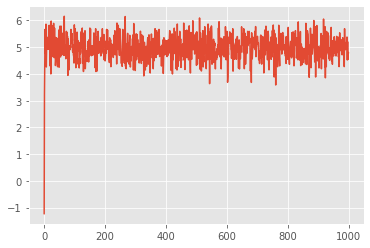

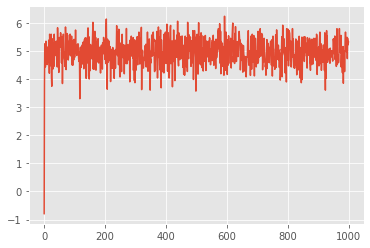

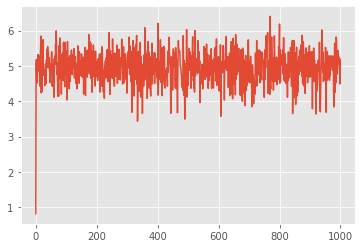

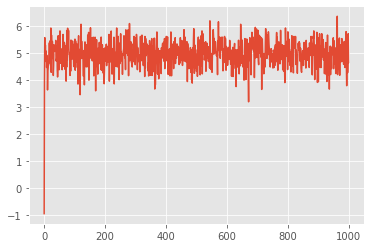

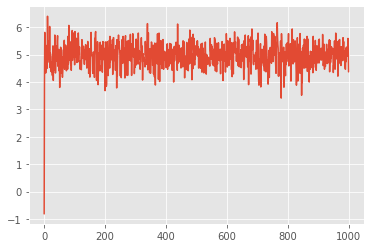

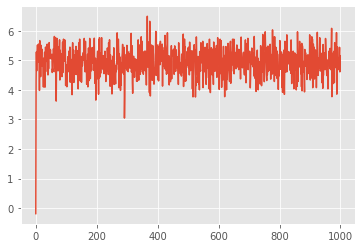

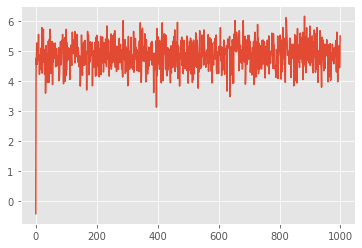

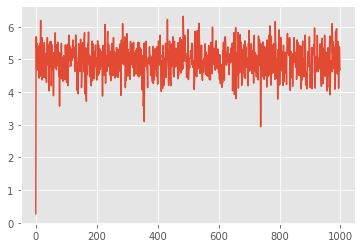

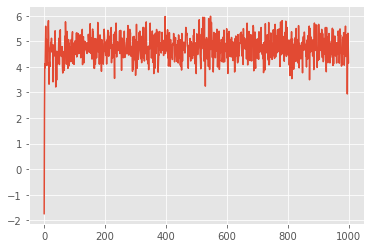

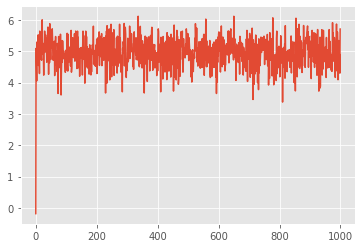

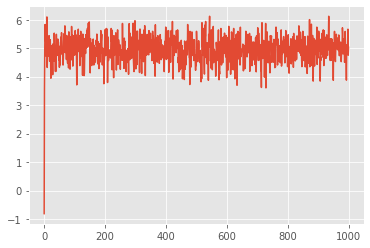

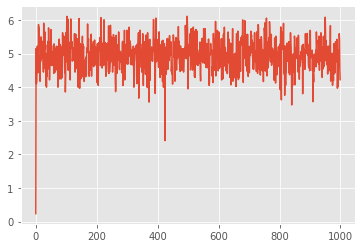

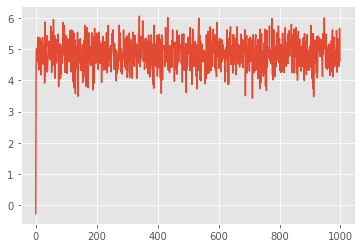

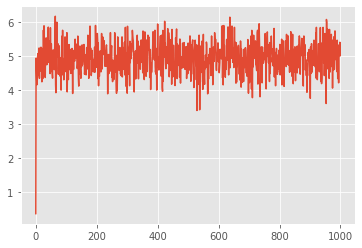

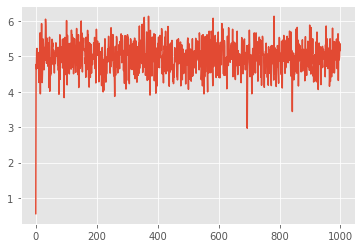

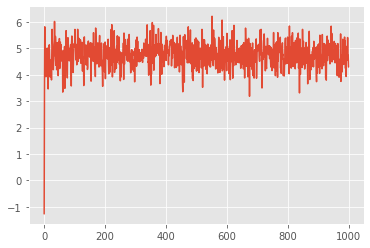

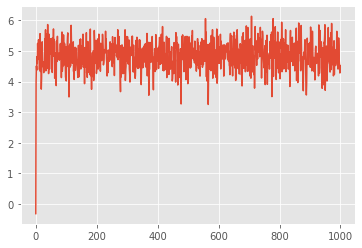

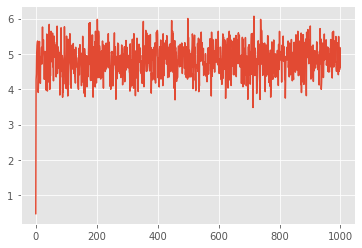

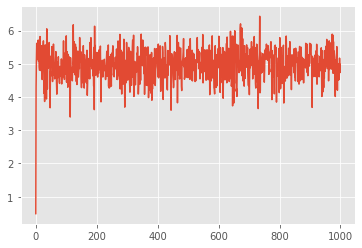

In [222]:
for i in range(20):
  plt.figure()
  plt.plot(average_r[i])

##2-STEP TREE BACKUP

In [274]:
class TreeBackupAgent(AgentBase):
  
    def __init__(self, id, environment):
      self.environment = environment
      super(TreeBackupAgent, self).__init__(id, environment)
      self.actions = 4
      self.discount = 0.9
      self.epsilon = 0.1
      self.Q_s_a = defaultdict(lambda: np.zeros(4))
      self.episodes = 40000
      self.alpha = 0.1
      self.decay = 0.99
      self.threshold = 0.1
      self.T = 100000

    def epsilon_greedy_policy(self, state):
        epsilon_policy = np.ones(self.actions, dtype=float) * self.epsilon / self.actions
        best_action = np.argmax(self.Q_s_a[state])
        epsilon_policy[best_action] += (1.0 - self.epsilon)
        return epsilon_policy


    def two_step_tree_backup(self):
      
      sum_r_per_episode = []
      num_of_r_per_episode = []

      for i in range(self.episodes):

        sum_r = 0
        cnt = 0
        state = self.environment.reset()
        done = False
        for t in itertools.count():
          #first_step
          probs = self.epsilon_greedy_policy(state)
          action = np.random.choice(np.arange(len(probs)), p = probs)
          prime_state, reward, _, _, _ = self.environment.step(action)
          # print("1",reward)
          sum_r += reward
          cnt += 1
          prime_probs = self.epsilon_greedy_policy(prime_state)
          prime_action = np.random.choice(np.arange(len(prime_probs)), p = prime_probs )
          double_prime_state, prime_reward, _, _, _ = self.environment.step(prime_action)
          # print("2",prime_reward)
          sum_r += prime_reward
          cnt += 1
          #second_step
          double_prime_probs = self.epsilon_greedy_policy(double_prime_state)
          double_prime_action = np.random.choice(np.arange(len(double_prime_probs)), p = double_prime_probs)
          triple_prime_state, double_prime_reward, done, _, _ = self.environment.step(double_prime_action)
          # print("3",double_prime_reward)
          sum_r += double_prime_reward
          cnt += 1
          info = [probs, state, action, reward]
          prime_info = [prime_probs, prime_state, prime_action, prime_reward]
          double_prime_info = [double_prime_probs, double_prime_state, double_prime_action, double_prime_reward]
          
          
          V = np.sum(prime_info[0] *self.Q_s_a[prime_info[1]])
          first_step = info[3] + self.discount * V

          prime_V = np.sum(double_prime_info[0] *self.Q_s_a[double_prime_info[1]])            
          first_step_error = prime_info[3] + self.discount * prime_V - self.Q_s_a[prime_info[1]][prime_info[2]]
          prime_action_selection_prob = max(prime_info[0])            

          second_step = self.discount * prime_action_selection_prob * first_step_error

          target = first_step + second_step 
          self.Q_s_a[info[1]][info[2]] += self.alpha * (target - self.Q_s_a[info[1]][info[2]])

          if done or t > self.T: 
            break
          state = prime_state
        # print("sum_r",sum_r)
        sum_r_per_episode.append(sum_r)  
        num_of_r_per_episode.append(cnt)
      window_size = 40
      average_reward =[]
      iter=0
      while iter < self.episodes:
        total_sum = 0
        total_cnt = 0
        for j in range(window_size):
          total_sum += sum_r_per_episode[iter+j]
          total_cnt += num_of_r_per_episode[iter+j]
        average_reward.append(total_sum/total_cnt)
        iter+=40
      return average_reward

In [276]:
import matplotlib.pyplot as plt
env = NSFrozenLake()
id = '1'
policy = None
agent1 = TreeBackupAgent(id, env)
average_r = []
start = time.time()
for i in range(20):
  print(i)
  r = agent1.two_step_tree_backup()
  average_r.append(r)
end = time.time()
print("run time =",end-start)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
run time = 1804.0988063812256


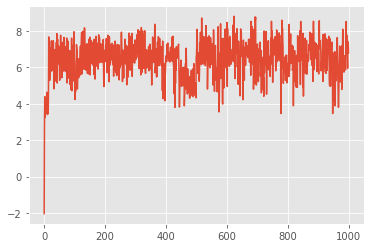

In [279]:
for i in range(1):
  plt.figure()
  plt.plot(average_r[i])

##MB and BF

In [67]:
class MB_MF(AgentBase):
  
    def __init__(self, id, environment):
      self.environment = environment
      super(MB_MF, self).__init__(id, environment)
      self.discount = 0.9
      self.epsilon = 0.1
      self.episodes = 10000
      self.alpha = 0.1
      self.decay = 0.99
      self.w = 0.8
    def action_epsilon_greedy(self, q, s):
      if np.random.rand() > self.epsilon:
        return np.argmax(q[s[0]][s[1]])
      else: 
        return np.random.randint(4)

    def combine_mb_mf(self):

      q_mf = [[[ 0 for _ in range(4)] for _ in range(4)] for _ in range(4)]
      q = [[[ 0 for _ in range(4)] for _ in range(4)] for _ in range(4)]
      q_mb = agent_mb.calc_QSA()
      
      sum_r_per_episode = []
      num_of_r_per_episode = []
      for i in range(self.episodes):
        sum_r = 0
        cnt = 0
        done = False
        s = self.environment.reset()
        
        s = list(s)
        while not done:
          a = self.action_epsilon_greedy(q, s)
          
          new_s, reward, done, probs, info = self.environment.step(a)
          sum_r += reward
          cnt += 1
          new_s = list(new_s)
          a_max = np.argmax(q_mf[new_s[0]][new_s[1]]) 
          target = reward + self.discount * q_mf[new_s[0]][new_s[1]][a_max]
          delta = target - q_mf[s[0]][s[1]][a]
          q_mf[s[0]][s[1]][a] += self.alpha * delta
          s = new_s
          self.alpha *= self.decay

          q[s[0]][s[1]][a] = self.w*q_mb[s[0]][s[1]][a] + (1-self.w)*q_mf[s[0]][s[1]][a]
        
        sum_r_per_episode.append(sum_r)  
        num_of_r_per_episode.append(cnt)
      window_size = 40
      average_reward =[]
      iter=0
      while iter < self.episodes:
        total_sum = 0
        total_cnt = 0
        for j in range(window_size):
          total_sum += sum_r_per_episode[iter+j]
          total_cnt += num_of_r_per_episode[iter+j]
        average_reward.append(total_sum/total_cnt)
        iter+=40
      return q, average_reward    


In [68]:
env = NSFrozenLake()
id = '1'
average_r = []
agent3 = MB_MF(id, env)
start = time.time()
for i in range(20):
  print(i)
  q, r = agent3.combine_mb_mf()
  average_r.append(r)
end = time.time()
print("run time =",end-start)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
run time = 193.49834275245667


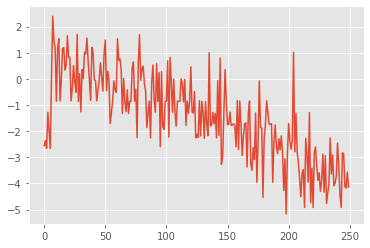

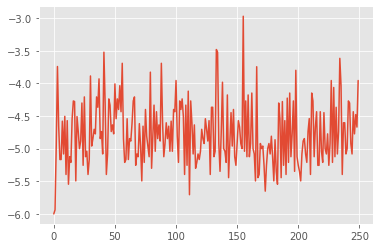

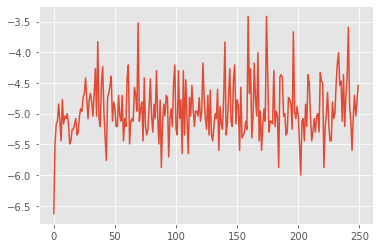

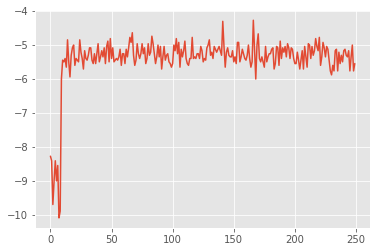

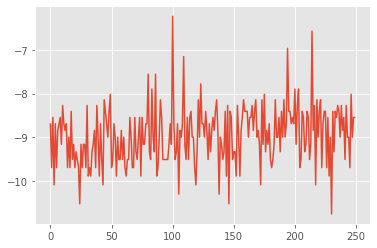

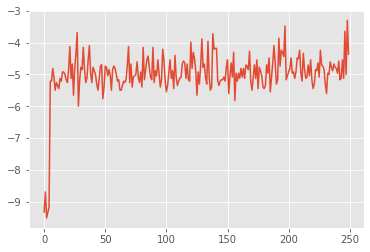

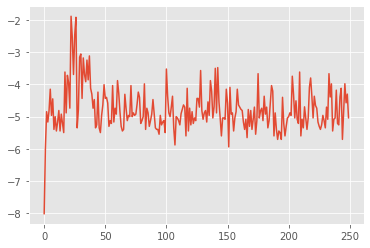

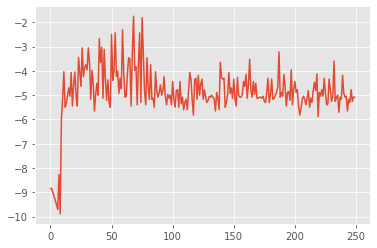

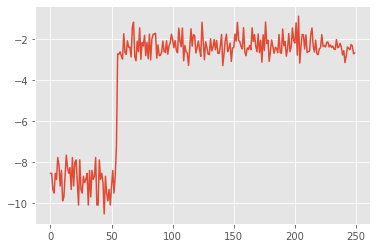

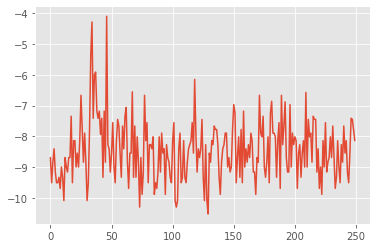

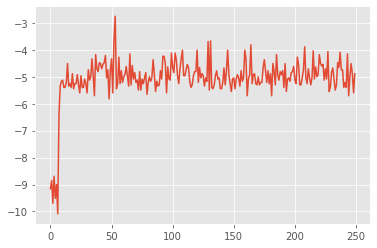

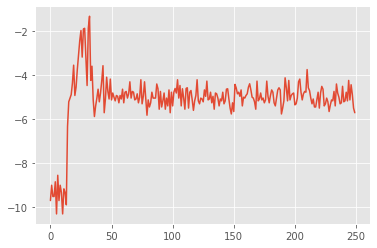

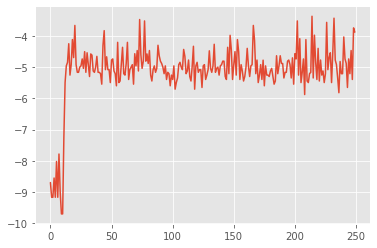

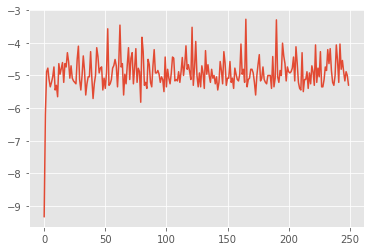

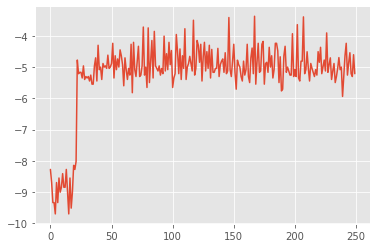

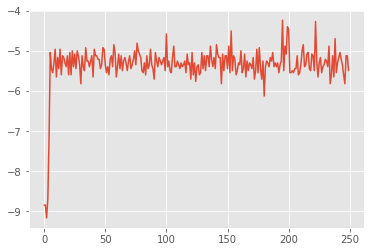

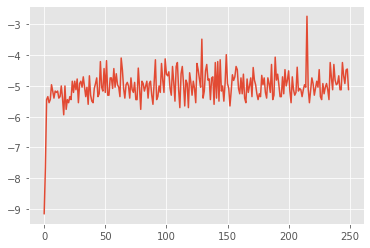

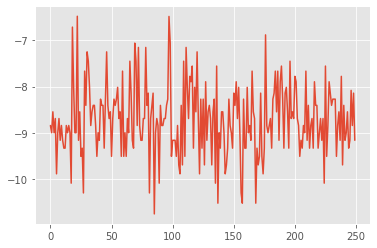

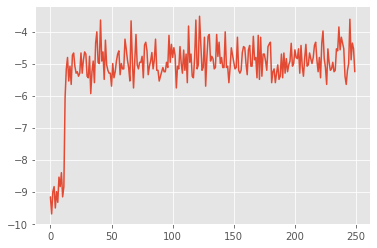

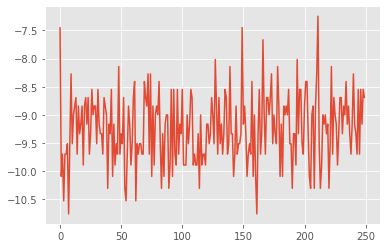

In [69]:
import matplotlib.pyplot as plt
for i in range(20):
  plt.figure()
  plt.plot(average_r[i])